In [27]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Sequential
from keras.initializers import Constant
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import regularizers

In [2]:
BASE_DIR = ''
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 150
MAX_NUM_WORDS = 4000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [3]:
# first, build index mapping words in the embeddings set
# to their embedding vector
#https://www.kaggle.com/terenceliu4444/glove6b100dtxt

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join('glove.6B.100d.txt'),encoding='utf-8') as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [4]:
X=[]
Y=[]
with open('clean-data.json','r') as f:
    d = json.load(f)
    X.extend(d['text'].values())
    Y.extend(d['sentiment'].values())


In [5]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6144 unique tokens.


In [6]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
tokenizer=Tokenizer()

tokenizer.fit_on_texts(Y)

Y = tokenizer.texts_to_matrix(Y)

Y = np.asarray([a[1:] for a in Y])

In [7]:
print(X)
print(Y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', Y.shape)

[[   0    0    0 ...    2  551   94]
 [   0    0    0 ...    2  150 2384]
 [   0    0    0 ...  136    5 2922]
 ...
 [   0    0    0 ... 2092 1030 1189]
 [   0    0    0 ...    1  274 1021]
 [   0    0    0 ...    0  420  663]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
Shape of data tensor: (1535, 150)
Shape of label tensor: (1535, 3)


In [8]:
(x_train,x_test,y_train,y_test)=train_test_split(X,Y,test_size=0.2,random_state=42)

In [9]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [11]:
rglrzr = regularizers.l2(0.1)

In [12]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(128, 3, activation='relu',kernel_regularizer=rglrzr))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          400100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 148, 128)          38528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 148, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 442,855
Trainable params: 42,755
Non-trainable params: 400,100
_________________________________________________________________

In [13]:
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Train on 982 samples, validate on 246 samples
Epoch 1/20
982/982 [==============================] - 2s 2ms/step - loss: 6.9548 - acc: 0.5804 - val_loss: 4.0549 - val_acc: 0.5732
Epoch 2/20
982/982 [==============================] - 2s 2ms/step - loss: 2.7273 - acc: 0.6018 - val_loss: 1.8045 - val_acc: 0.6260
Epoch 3/20
982/982 [==============================] - 2s 2ms/step - loss: 1.3952 - acc: 0.6507 - val_loss: 1.2082 - val_acc: 0.6504
Epoch 4/20
982/982 [==============================] - 2s 2ms/step - loss: 1.0677 - acc: 0.6405 - val_loss: 1.0374 - val_acc: 0.6707
Epoch 5/20
982/982 [==============================] - 2s 2ms/step - loss: 0.9368 - acc: 0.6935 - val_loss: 0.9735 - val_acc: 0.6748
Epoch 6/20
982/982 [==============================] - 2s 2ms/step - loss: 0.9201 - acc: 0.6772 - val_loss: 0.9388 - val_acc: 0.6829
Epoch 7/20
982/982 [==============================] - 2s 2ms/step - loss: 0.8897 - acc: 0.6823 - val_loss: 0.9298 - val_acc: 0.7033
Epoch 8/20
982/982 [==========

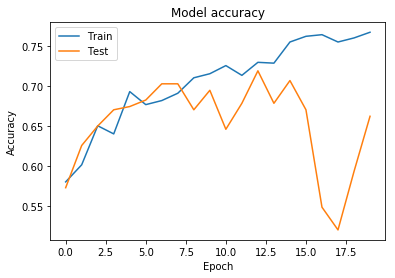

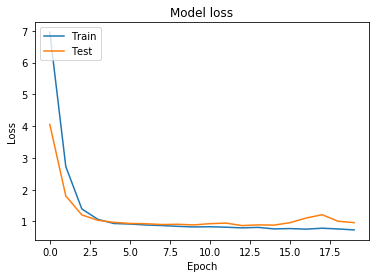

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:
import math
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
#from pandas_ml import ConfusionMatrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import itertools

In [29]:
y_pred = model.predict(x_test)
def binar(li):
    if li[0]>li[1] and li[0]>li[2] :
        return 'positive'
    if li[1]>li[2] and li[1]>li[0] :
        return 'neutral'
    return 'negative'
y_pre=[binar(y) for y in y_pred]
y_tes=[binar(y) for y in y_test]

In [30]:
confusion_matrix(y_true=y_tes,y_pred=y_pre)

array([[  0,   9,  23],
       [  0,  57,  59],
       [  0,  25, 134]], dtype=int64)

In [31]:
cnf_matrix = confusion_matrix(y_tes, y_pre)
acc_score = accuracy_score(y_tes, y_pre)

print('Accuracy Score: ', acc_score)
print(cnf_matrix)

Accuracy Score:  0.6221498371335505
[[  0   9  23]
 [  0  57  59]
 [  0  25 134]]


In [32]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

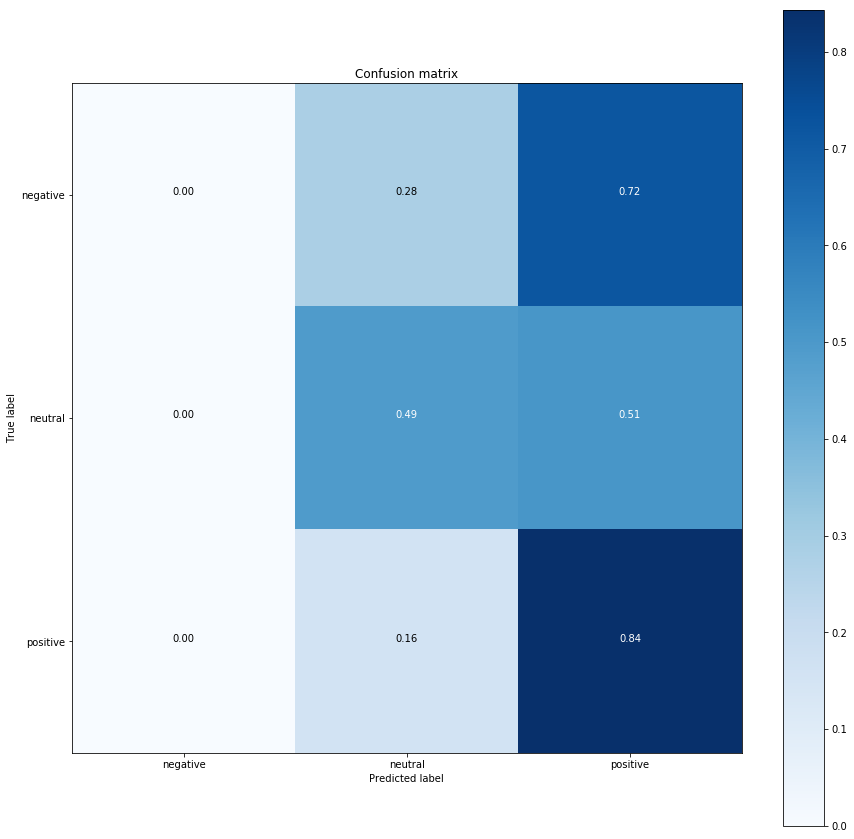

In [33]:
text_labels = ['negative','neutral','positive']

plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()